# INGV - Volcanic Eruption Prediction Compete
### Notebook : Introduction to Volcanology, Seismograms and LGBM from Jesper Sören Dramsch
https://www.kaggle.com/jesperdramsch/introduction-to-volcanology-seismograms-and-lgbm

### Data

`segment_id`: 화산 id. 

`time_to_eruption`: 다음 폭발까지의 시간. target value. 

`[train|test]/*.csv`: 화산 주변 10개 sensor의 10분 간격 값. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm import tqdm # progress bar

random_state = 100

In [2]:
train = pd.read_csv("../input/predict-volcanic-eruptions-ingv-oe/train.csv")
train.tail()

,segment_id,time_to_eruption
4426,873340274,15695097
4427,1297437712,35659379
4428,694853998,31206935
4429,1886987043,9598270
4430,1100632800,20128938


In [3]:
sequence = pd.read_csv("../input/predict-volcanic-eruptions-ingv-oe/train/1000015382.csv", dtype = "Int16")
sequence.tail()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10
59996,245,75,-306,307,-49,118,361,824,-25,371
59997,248,29,-398,145,-29,196,308,892,-38,408
59998,146,-100,-525,10,-5,344,217,837,-137,509
59999,86,-275,-619,-72,16,354,171,602,7,648
60000,103,-313,-648,-162,33,527,137,238,-40,695


In [4]:
sequence.describe()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10
count,60001.000000,59847.000000,60001.000000,60001.000000,60001.000000,60001.000000,60001.000000,60001.000000,60001.000000,60001.000000
mean,0.382244,2.266563,2.192213,-0.148031,-0.263129,1.630089,-0.615190,-0.177964,-0.402777,0.896752
std,111.553322,451.741111,373.923764,231.812464,129.504432,222.294642,269.678045,319.999406,176.087814,249.024286
min,-920.000000,-7871.000000,-2444.000000,-1815.000000,-2484.000000,-1128.000000,-1453.000000,-2947.000000,-1585.000000,-2961.000000
25%,-66.000000,-163.000000,-223.000000,-150.000000,-30.000000,-147.000000,-172.000000,-194.000000,-106.000000,-117.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,67.000000,168.000000,224.000000,149.000000,30.000000,149.000000,174.000000,195.000000,106.000000,119.000000
max,822.000000,7321.000000,2563.000000,1491.000000,2608.000000,1119.000000,1668.000000,3676.000000,1162.000000,3179.000000


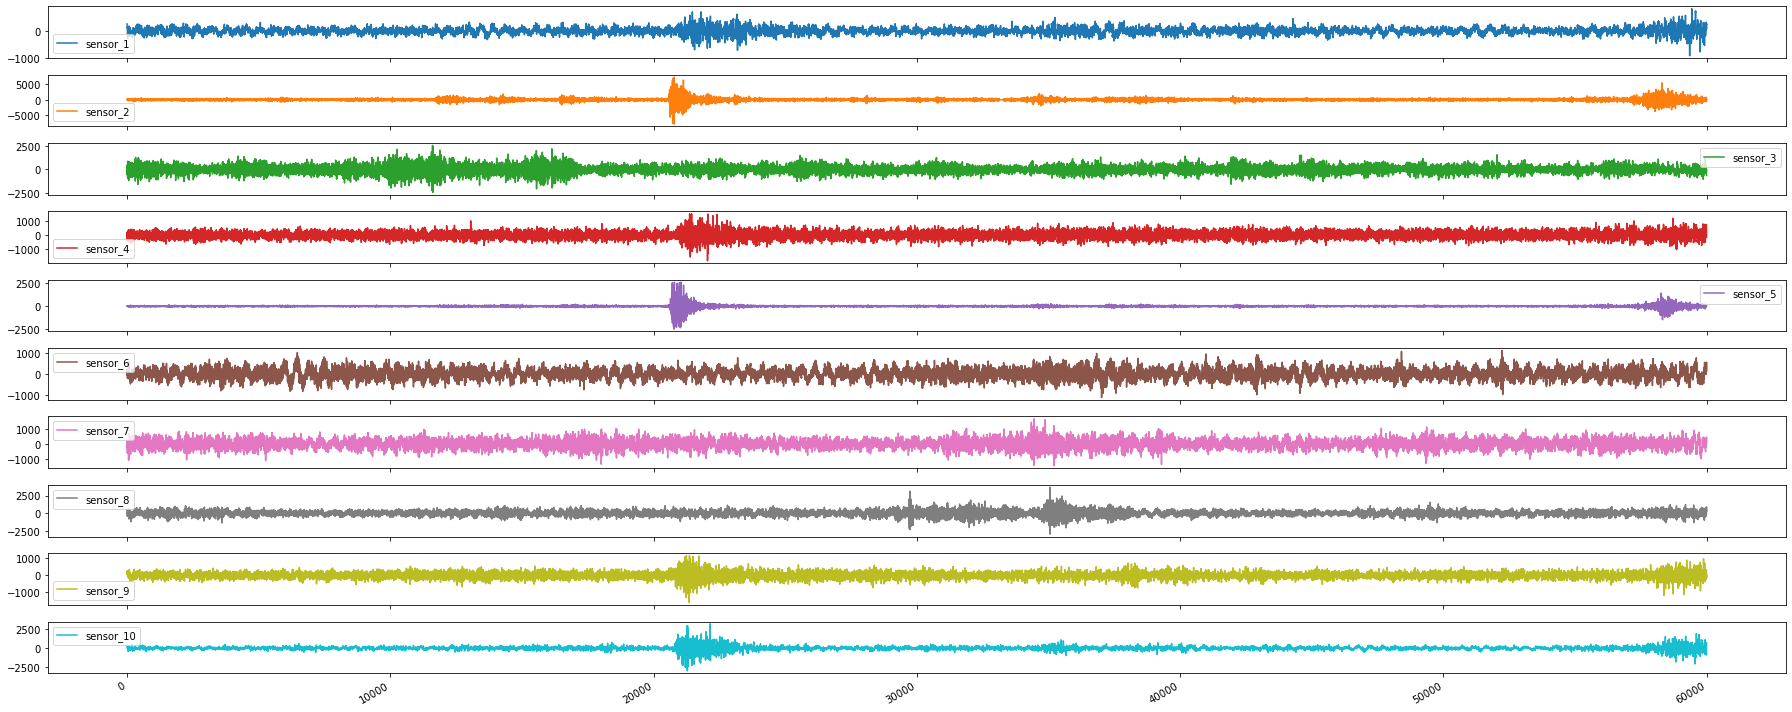

In [5]:
sequence.fillna(0).plot(subplots = True, figsize = (25, 10))
plt.tight_layout()
plt.show()

1. data가 비슷하지만 시간이 shift되어 보인다. 
왜? 한 signal event 발생 지점에서 sensor가 위치한 거리가 다 다르니까. 
ex) 한 signal event 발생 지점에서 sensor_9와 sensor_10은 거리가 비슷하고 sensor_8은 좀 멀리 있다. 

2. sensor마다 noise 수준이 다르다. 
sensor_5는 큰 사건에만 반응하여 매우 조용하지만 sensor_6는 noise가 주기적으로 있다. 

전체적으로 sensor는 화산 활동이 어디서 일어나느냐에 따라 다른 지연을 가진다. 모델이 time series를 사용한다면 기억해라. 

In [6]:
def agg_stats(df, idx):
    df = df.agg(['sum', 'min', "mean", "std", "median", "skew", "kurtosis"])
    df_flat = df.stack()
    df_flat.index = df_flat.index.map('{0[1]}_{0[0]}'.format)
    df_out = df_flat.to_frame().T
    df_out["segment_id"] = int(idx)
    return df_out

In [7]:
summary_stats = pd.DataFrame()
for csv in tqdm(Path("../input/predict-volcanic-eruptions-ingv-oe/train/").glob("**/*.csv"), total = 4431):
    df = pd.read_csv(csv)
    summary_stats = summary_stats.append(agg_stats(df, csv.stem))

 98%|█████████▊| 4431/4501 [12:25<00:11,  5.94it/s]


In [8]:
test_data = pd.DataFrame()
for csv in tqdm(Path("../input/predict-volcanic-eruptions-ingv-oe/test/").glob("**/*.csv"), total = 4520):
    df = pd.read_csv(csv)
    test_data = test_data.append(agg_stats(df, csv.stem))

4520it [12:16,  6.14it/s]                          


In [9]:
summary_stats

,sensor_1_sum,sensor_2_sum,sensor_3_sum,sensor_4_sum,sensor_5_sum,sensor_6_sum,sensor_7_sum,sensor_8_sum,sensor_9_sum,sensor_10_sum,...,sensor_3_mean,sensor_9_mean,sensor_3_std,sensor_9_std,sensor_3_median,sensor_9_median,sensor_3_skew,sensor_9_skew,sensor_3_kurtosis,sensor_9_kurtosis
0,246860.0,190832.0,0.0,222795.0,-23542.0,-1633857.0,-378117.0,-250538.0,0.0,539840.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,-8760.0,-110423.0,-158561.0,-45063.0,-72167.0,-49231.0,-184887.0,148202.0,205683.0,4258.0,...,-2.642639,3.427993,583.100251,680.014886,0.0,0.0,-0.018962,0.002706,0.173209,0.200506
0,49504.0,0.0,166995.0,70822.0,43758.0,-130730.0,-67101.0,0.0,154.0,-207969.0,...,2.783204,0.002567,247.931506,289.998896,0.0,0.0,0.122184,0.012443,1.560024,1.297561
0,-89445.0,68666.0,-322248.0,116084.0,-31568.0,1507883.0,1447249.0,-366456.0,452929.0,936166.0,...,-5.370710,7.548691,526.238300,541.287068,0.0,0.0,-0.044987,0.059949,-0.006577,0.252821
0,-44225.0,405037.0,234170.0,171577.0,6933.0,-208817.0,86905.0,70251.0,94008.0,298896.0,...,3.902768,1.566774,331.748050,343.404396,0.0,0.0,-0.052081,-0.002466,3.931743,2.108477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,-68586.0,61419.0,25312.0,-61766.0,21416.0,85894.0,26150.0,-48041.0,4174.0,-161473.0,...,0.421860,0.069566,300.605569,440.959564,0.0,0.0,0.254843,0.293409,19.367581,31.886122
0,-108260.0,-113013.0,468737.0,132240.0,42942.0,-462284.0,-551958.0,-1008034.0,78257.0,368684.0,...,7.812153,1.304262,516.902625,557.335248,0.0,0.0,0.025337,0.024627,0.297317,0.341008
0,72298.0,-29093.0,-60052.0,-79161.0,-25260.0,-126039.0,-97781.0,-93626.0,-124829.0,394018.0,...,-1.000850,-2.080449,183.123949,220.964863,0.0,0.0,-0.022783,-0.042452,0.842513,1.275213
0,158727.0,-136707.0,222378.0,-121133.0,24867.0,-77309.0,56890.0,-33145.0,221007.0,-85096.0,...,3.706238,3.683389,287.223300,283.679520,0.0,0.0,0.070080,0.034589,0.048079,0.147923


In [10]:
test_data

,sensor_1_sum,sensor_2_sum,sensor_3_sum,sensor_4_sum,sensor_5_sum,sensor_6_sum,sensor_7_sum,sensor_8_sum,sensor_9_sum,sensor_10_sum,...,sensor_8_kurtosis,sensor_9_kurtosis,sensor_10_kurtosis,segment_id,sensor_2_min,sensor_2_mean,sensor_2_std,sensor_2_median,sensor_2_skew,sensor_2_kurtosis
0,176053.0,0.0,256674.0,-332689.0,-132049.0,513231.0,-144172.0,91820.0,-57767.0,-182668.0,...,0.047616,0.599324,0.311241,473253715,NaN,NaN,NaN,NaN,NaN,NaN
0,-163264.0,-163473.0,210484.0,-160025.0,-160063.0,-138917.0,63258.0,-19571.0,-141810.0,314689.0,...,0.674631,1.549404,2.389208,698018079,-32767.0,-2.724505,1742.047382,0.0,-0.333724,31.380589
0,-61271.0,0.0,0.0,-39293.0,-35512.0,13346.0,331228.0,2194.0,38243.0,0.0,...,-0.030561,0.425849,0.000000,1102809614,NaN,NaN,NaN,NaN,NaN,NaN
0,23641.0,8068.0,88471.0,-99968.0,41230.0,72076.0,-27421.0,-95106.0,106812.0,-627041.0,...,1.255523,0.689637,0.168186,1087681649,-2396.0,0.134464,400.391725,0.0,0.013306,0.938544
0,-217318.0,0.0,-204164.0,-31475.0,16878.0,142299.0,84423.0,0.0,3441.0,-145282.0,...,NaN,3.120450,4.527737,1939361933,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,34096.0,89653.0,-58196.0,36652.0,-44922.0,-2662.0,56554.0,-50416.0,-51077.0,-71848.0,...,0.168505,2.967956,2.768301,1716645489,-4672.0,1.494192,408.491517,0.0,0.004185,9.928462
0,-240731.0,232798.0,-162261.0,-316943.0,68122.0,828646.0,227291.0,8299.0,-110478.0,309510.0,...,-0.062901,3.259150,4.243732,1799317581,-7564.0,3.879902,605.592628,0.0,-0.267614,22.236006
0,-154754.0,0.0,-178714.0,-34850.0,-1614.0,-8258.0,58747.0,683738.0,-16350.0,0.0,...,0.478004,0.174830,0.000000,1284692270,NaN,NaN,NaN,NaN,NaN,NaN
0,30926.0,-27446.0,-89772.0,-70809.0,-24654.0,-471911.0,454623.0,-295188.0,12871.0,-427970.0,...,0.677760,0.666131,0.385648,531629727,-4117.0,-0.457426,354.425103,0.0,0.134761,11.830129


In [11]:
temp = summary_stats.drop(["segment_id"], axis = 1) # 'segment_id' column 지우기
features = list(temp.columns) # 'sensor_0_agg' column list. 총 70개. 
target_name = ["time_to_eruption"]

In [12]:
summary_stats = summary_stats.merge(train, on = "segment_id") # summary_stats에 'segment_id' 기준으로 train의 'time_to_eruption'을 붙인다. 
summary_stats.head()
# summary_stats.columns : 'sensor_0_agg' * 70, 'segment_id', 'time_to_eruption'

,sensor_1_sum,sensor_2_sum,sensor_3_sum,sensor_4_sum,sensor_5_sum,sensor_6_sum,sensor_7_sum,sensor_8_sum,sensor_9_sum,sensor_10_sum,...,sensor_9_mean,sensor_3_std,sensor_9_std,sensor_3_median,sensor_9_median,sensor_3_skew,sensor_9_skew,sensor_3_kurtosis,sensor_9_kurtosis,time_to_eruption
0,246860.0,190832.0,0.0,222795.0,-23542.0,-1633857.0,-378117.0,-250538.0,0.0,539840.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16818516
1,-8760.0,-110423.0,-158561.0,-45063.0,-72167.0,-49231.0,-184887.0,148202.0,205683.0,4258.0,...,3.427993,583.100251,680.014886,0.0,0.0,-0.018962,0.002706,0.173209,0.200506,10340827
2,49504.0,0.0,166995.0,70822.0,43758.0,-130730.0,-67101.0,0.0,154.0,-207969.0,...,0.002567,247.931506,289.998896,0.0,0.0,0.122184,0.012443,1.560024,1.297561,40087733
3,-89445.0,68666.0,-322248.0,116084.0,-31568.0,1507883.0,1447249.0,-366456.0,452929.0,936166.0,...,7.548691,526.238300,541.287068,0.0,0.0,-0.044987,0.059949,-0.006577,0.252821,31317486
4,-44225.0,405037.0,234170.0,171577.0,6933.0,-208817.0,86905.0,70251.0,94008.0,298896.0,...,1.566774,331.748050,343.404396,0.0,0.0,-0.052081,-0.002466,3.931743,2.108477,5801334


In [13]:
summary_stats.describe()

,sensor_1_sum,sensor_2_sum,sensor_3_sum,sensor_4_sum,sensor_5_sum,sensor_6_sum,sensor_7_sum,sensor_8_sum,sensor_9_sum,sensor_10_sum,...,sensor_9_mean,sensor_3_std,sensor_9_std,sensor_3_median,sensor_9_median,sensor_3_skew,sensor_9_skew,sensor_3_kurtosis,sensor_9_kurtosis,time_to_eruption
count,4.431000e+03,4.431000e+03,4.431000e+03,4.431000e+03,4.431000e+03,4.431000e+03,4.431000e+03,4.431000e+03,4.431000e+03,4.431000e+03,...,4307.000000,3996.000000,4307.000000,3996.0,4307.0,3996.000000,4307.000000,3996.000000,4307.000000,4.431000e+03
mean,-3.154637e+04,6.642264e+04,-7.115497e+04,-6.911549e+03,1.703888e+05,8.371901e+03,-9.131113e+03,-3.930828e+02,-6.063665e+03,-1.970177e+04,...,-0.088121,658.951399,677.088265,0.0,0.0,-0.000991,-0.003657,1.779537,2.248869,2.284891e+07
std,1.074697e+06,4.234405e+06,1.454592e+06,1.199746e+06,4.345850e+06,1.432993e+06,1.206980e+06,1.390008e+06,1.227877e+06,2.005872e+06,...,20.776701,1533.866852,1626.207259,0.0,0.0,0.114722,0.093619,10.429411,7.854015,1.348439e+07
min,-3.572893e+07,-1.471348e+07,-3.467549e+07,-2.729633e+07,-6.630852e+06,-4.027425e+07,-4.723766e+07,-5.815644e+07,-2.519325e+07,-6.419481e+07,...,-419.880502,83.034849,102.552075,0.0,0.0,-1.165676,-2.739765,-1.163593,-0.876845,6.250000e+03
25%,-1.072995e+05,-8.585300e+04,-1.087195e+05,-9.845400e+04,-2.699850e+04,-1.762360e+05,-1.396805e+05,-1.101665e+05,-8.263250e+04,-1.987590e+05,...,-1.455901,242.923509,284.182257,0.0,0.0,-0.037239,-0.029876,0.174041,0.256607,1.127016e+07
50%,1.062000e+03,0.000000e+00,0.000000e+00,-1.022000e+03,0.000000e+00,1.836000e+03,7.731000e+03,0.000000e+00,0.000000e+00,5.861000e+03,...,0.040475,321.968464,346.935743,0.0,0.0,-0.001881,-0.001719,0.426267,0.669426,2.246559e+07
75%,1.095300e+05,8.361850e+04,8.270450e+04,9.850450e+04,2.645550e+04,1.744185e+05,1.313650e+05,1.173110e+05,8.784450e+04,2.270125e+05,...,1.526947,534.883686,514.422366,0.0,0.0,0.033900,0.024996,1.183498,1.803676,3.434356e+07
max,2.047363e+07,2.687404e+08,3.331265e+07,3.894129e+07,1.799850e+08,5.094290e+07,2.035339e+07,4.406151e+07,4.512942e+07,6.134024e+07,...,752.144481,19900.334691,18925.747540,0.0,0.0,2.085865,0.886424,448.313264,264.051749,4.904609e+07


### LightGBM
: Light Gradient Boosting Machine

Ensemble Boosting 알고리즘.  
xgboost는 좋은 성능을 보이지만 학습시간이 느리다.   
LightGBM은 대용량 데이터 처리 가능, 적은 자원(메모리) 사용, 빠름, GPU 지원.   

기존 boosting 모델은 level-wise tree growth(수평 확장)인데, lightgbm은 leaf-wise(수직 확장) 트리 분할을 사용한다.   
level wise는 트리 균형을 맞추기 위해 depth가 줄고 연산이 추가된다. leaf wise는 트리의 균형을 맞추지 않는다.   
손실을 줄일 수 있다.  
데이터가 적은 경우 overfitting이 되기 쉽다. 

참고 사이트   
https://injo.tistory.com/48   
https://lsjsj92.tistory.com/548   
https://greatjoy.tistory.com/72

In [14]:
import lightgbm as lgbm
from sklearn.model_selection import KFold
# import gc

n_fold = 7
folds = KFold(n_splits = n_fold, shuffle = True, random_state = random_state)

data = summary_stats

params = {
    "n_estimators": 2000,
    "boosting_type": "gbdt",
    "metric": "mae", 
    "num_leaves": 66, 
    "learning_rate": 0.005, 
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8, 
    "agging_freq": 3,
    "max_bins": 2048,
    "verbose": 0,
    "random_state": random_state,
    "nthread": -1,
    "device": "gpu",
}

sub_preds = np.zeros(test_data.shape[0]) # array which has 4520 length
feature_importance = pd.DataFrame(index = list(range(n_fold)), columns = features) # 7 rows x 70 columns filled with NaN

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(data)):
    trn_x, trn_y = data[features].iloc[trn_idx], data[target_name].iloc[trn_idx]
    val_x, val_y = data[features].iloc[val_idx], data[target_name].iloc[val_idx]
    
    model = lgbm.LGBMRegressor(**params)
    
    model.fit(trn_x, trn_y, eval_set = [(trn_x, trn_y), (val_x, val_y)], eval_metric = "mae", verbose = 0, early_stopping_rounds = 150)

#     매 학습마다 feature_importances_를 저장한다. 
    feature_importance.iloc[n_fold, :] = model.feature_importances_
    
#     예측값을 n_fold로 나눈 후 sub_preds에 더한다. n_fold가 모두 끝나면 sub_preds에는 예측값의 평균이 저장된다. 
    sub_preds += model.predict(test_data[features], num_iteration = model.best_iteration_) / folds.n_splits 

In [15]:
feature_importance

,sensor_1_sum,sensor_2_sum,sensor_3_sum,sensor_4_sum,sensor_5_sum,sensor_6_sum,sensor_7_sum,sensor_8_sum,sensor_9_sum,sensor_10_sum,...,sensor_3_mean,sensor_9_mean,sensor_3_std,sensor_9_std,sensor_3_median,sensor_9_median,sensor_3_skew,sensor_9_skew,sensor_3_kurtosis,sensor_9_kurtosis
0,903,760,955,1360,936,1290,1259,1204,757,1025,...,1425,1093,2768,3244,0,0,2378,2165,2976,2491
1,1038,730,848,1178,986,1285,1221,1036,974,889,...,1237,1098,2647,3314,0,0,2380,1877,3158,2311
2,754,840,691,1197,1158,1350,1197,1057,922,874,...,1269,1247,2736,3152,0,5,2106,2109,3207,2324
3,912,843,762,1222,1180,1336,1164,977,1015,1011,...,1292,1093,2734,3171,1,0,2071,2089,2852,2045
4,869,866,936,1308,1002,1254,1256,1128,816,998,...,1240,1161,2557,3385,0,0,1959,2053,2857,2556
5,810,1060,879,1315,1127,1218,1164,912,733,1055,...,1343,1268,2652,3248,2,0,2587,1936,3079,2210
6,913,969,825,1256,927,1248,976,1116,722,882,...,1371,1002,2778,3496,0,0,2161,2255,3045,2282


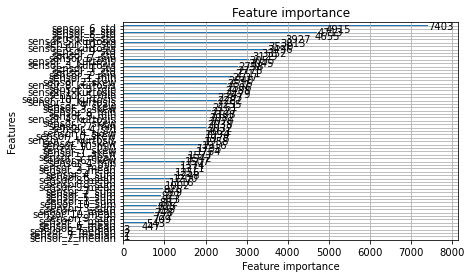

In [17]:
lgbm.plot_importance(model)

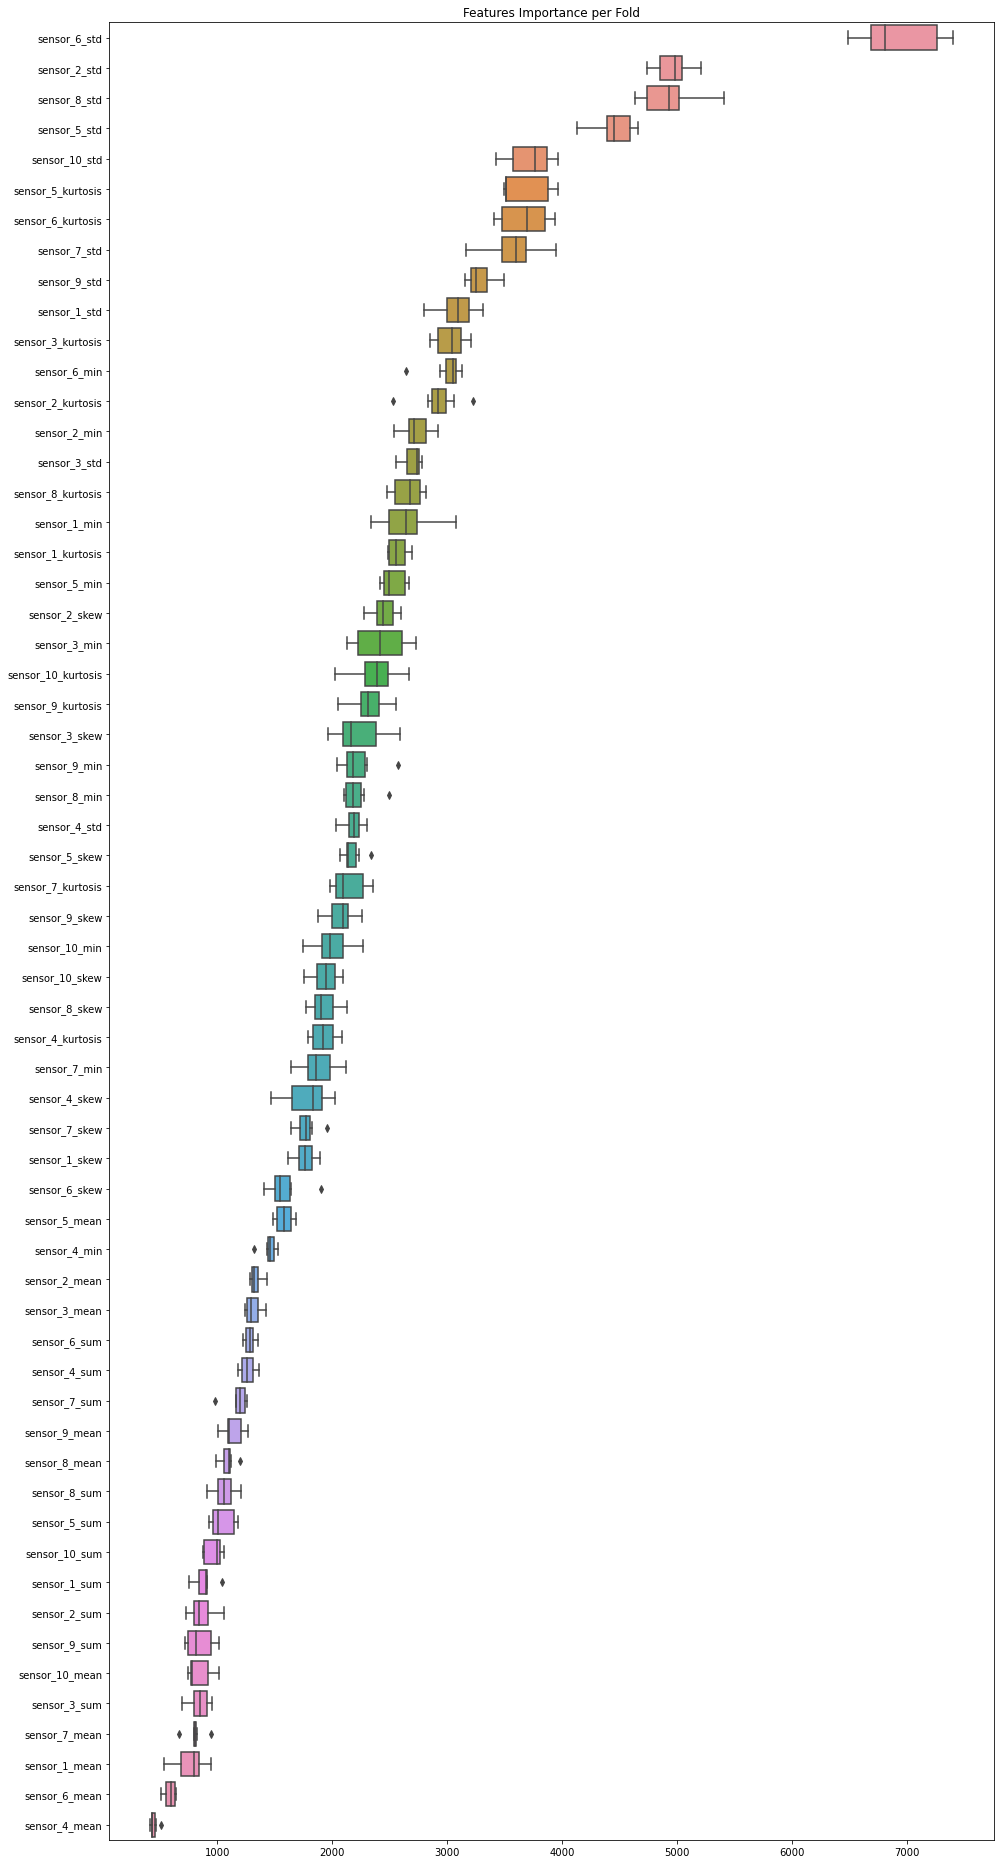

In [18]:
best = feature_importance.mean().sort_values(ascending = False) # 내림차순 정렬
best_idx = best[best > 5].index

plt.figure(figsize = (14,26))
sns.boxplot(data = feature_importance[best_idx], orient = "h") # horizontal
plt.title("Features Importance per Fold")
plt.tight_layout()

In [19]:
submission = pd.DataFrame()
submission['segment_id'] = test_data["segment_id"]
submission['time_to_eruption'] = sub_preds
submission.to_csv('submission.csv', header = True, index = False)